In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
import numpy as np

## **Gathering Data**
Blok ini berusaha untuk memperoleh data yang diambil dari database ..., terdiri dari data alokasi Jawa Tengah (*alokasi_jawa_tengah.xlsx*) pada sheet Alokasi Desa, data realisasi penjualan (*GI_Jateng_Jan_Okt_2024.xlsx*), 57 Distribution Center (Lini 3) Existing di Jawa Tengah (57 DC.xlsx). Data desa yang diperoleh melalui folder **data_administrasi_wilayah_indonesia** yang di filter pada bagian kode provinsi untuk perolehan desa yang sudah dilakukan dalam `(Versi 57 DC) Data Optimasi Distribusi Jawa Tengah` pada sheet **Sheet2**. Data lokasi kios yang didapatkan dari DPCS.

In [4]:
kios_file_aws = 'kios_aws.csv'
desa_file_aws = 'desa_aws_8264.csv'

In [5]:
# data kios jateng, data dc existing di jateng, data desa jateng
alokasi_df = pd.read_excel("raw_data/alokasi_jawa_tengah.xlsx",sheet_name="Alokasi Desa")
alokasi_df.drop(columns="No",inplace=True)
alokasi_df.head()

,Kabupaten/Kota,Urea,NPK,NPK Kakao,Organik,Total,Kios,Desa,%kios/desa,Alokasi/tahun,Alokasi/bulan,KabKotasKios,KabKota
0,Banjarnegara,17069.411,17047.748,0.0,175.0,34292.159,72,266,0.270677,128.917891,10.743158,KAB. BANJARNEGARA,BANJARNEGARA
1,Banyumas,20354.270,14806.706,0.0,2107.0,37267.976,192,301,0.637874,123.813874,10.317823,KAB. BANYUMAS,BANYUMAS
2,Batang,14670.568,12968.868,0.0,249.0,27888.436,63,239,0.263598,116.688017,9.724001,KAB. BATANG,BATANG
3,Blora,65815.932,50754.146,0.0,40000.0,156570.078,366,271,1.350554,577.749365,48.145780,KAB. BLORA,BLORA
4,Boyolali,24028.492,24949.469,0.0,7732.0,56709.961,153,261,0.586207,217.279544,18.106629,KAB. BOYOLALI,BOYOLALI


In [6]:
# Data berasal dari
desa_df = pd.read_excel("desa_8264.xlsx",sheet_name="Sheet1")
desa_df.rename(columns={"Desa":"Nama_Desa"},inplace=True)
desa_df.head()

,id,customers,address,kabkota,provinsi,alokasi_per_bulan,lat_customers,lon_customers,nearest_plant_existing,lat_plant_existing,lon_plant_existing
0,Purbalingga - Kebong_ADIARSA,ADIARSA,-,KAB. PURBALINGGA,JAWA TENGAH,7.60,-7.28733,109.429,Purbalingga - Kebong,-7.40331,109.3588
1,GPP KEBUMEN_ADIKARSO,ADIKARSO,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.69377,109.673,GPP KEBUMEN,-7.61092,109.5078
2,GPP KEBUMEN_ADIKARTO,ADIKARTO,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.66904,109.589,GPP KEBUMEN,-7.61092,109.5078
3,GPP MAGELANG_ADIKARTO,ADIKARTO,-,KAB. MAGELANG,JAWA TENGAH,7.61,-7.60788,110.245,GPP MAGELANG,-7.39554,110.2447
4,GPP KEBUMEN_ADILUHUR,ADILUHUR,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.68421,109.559,GPP KEBUMEN,-7.61092,109.5078


In [7]:
# Data berasal dari pemasaran dan di filter khusus untuk kios jawa tengah yang aktif
kios_df = pd.read_excel("raw_data/kios_jateng_aktif.xlsx")
kios_df.rename(columns={'Name':'Nama_Kios'},inplace=True)
kios_df.head()

,Code,Nama_Kios,Address,Kecamatan,Kabupaten,Provinsi,LokasiLat,LokasiLong,Maps
0,RT0000016817,"AJAIB, UD",DUSUN SAMBIROTO RT5/RW3 DESA RINGINPITU,Tanggungharjo,KAB. GROBOGAN,JAWA TENGAH,-7.117652,110.602219,"https://www.google.com/maps?q=-7,1176515,110,6..."
1,RT0000016818,"TANI BAROKAH, UD",DUSUN SAMBIROTO RT6/RW3 DESA RINGINPITU,Tanggungharjo,KAB. GROBOGAN,JAWA TENGAH,-7.115319,110.601943,"https://www.google.com/maps?q=-7,1153192,110,6..."
2,RT0000017258,KIOS CAHAYA ABADI,"KARANGREJA RT. 004, RW. 002",Cimanggu,KAB. CILACAP,JAWA TENGAH,-7.311356,108.801280,"https://www.google.com/maps?q=-7,311356,108,80..."
3,RT0000017259,KIOS MITRA TANI,DESA KARANGREJA,Cimanggu,KAB. CILACAP,JAWA TENGAH,-7.349698,108.801121,"https://www.google.com/maps?q=-7,3496982,108,8..."
4,RT0000017260,UD. BAROKAH,BANJARPARAKAN,Rawalo,KAB. BANYUMAS,JAWA TENGAH,-7.538038,109.165297,"https://www.google.com/maps?q=-7,5380383,109,1..."


In [8]:
real_sales_df = pd.read_excel("raw_data/GI_Jateng_Jan_Okt_2024.xlsx",engine='openpyxl')
real_sales_df.head()

,SalesOrganization,NomorSalesOrder,TanggalSODibuat,NomorDO,TanggalPGI,BulanPGI,NamaDistributor,Sektor,SoType,Customer Group,...,ProvDes,IdKab,Kab,DeliveryItem,MaterialGroup,NomorMaterial,Deskripsi Material,QuantitySO,QuantityPGI,UOM SO
0,H000,3018889828,2024-01-11,5004517728,2024-01-02,January,ANNI,SUBSIDI,Z3SM,Z1,...,JAWA TENGAH,306.0,KAB. PURBALINGGA,10,P011121,1000036,Urea SUB @50 KG,2.0,2.0,TON
1,H000,3018889829,2024-01-11,5004517729,2024-01-02,January,SUBUR TANI,SUBSIDI,Z3SM,Z1,...,JAWA TENGAH,306.0,KAB. PURBALINGGA,10,P011121,1000036,Urea SUB @50 KG,3.0,3.0,TON
2,H000,3018889842,2024-01-11,5004517744,2024-01-02,January,REFIAN JAYA,SUBSIDI,Z3SM,Z1,...,JAWA TENGAH,307.0,KAB. BANJARNEGARA,10,P011121,1000036,Urea SUB @50 KG,7.5,7.5,TON
3,H000,3018890366,2024-01-30,5004518310,2024-01-02,January,ANUGERAH TANI,SUBSIDI,Z3SM,Z1,...,JAWA TENGAH,310.0,KAB. WONOSOBO,10,P011121,1000036,Urea SUB @50 KG,9.0,9.0,TON
4,H000,3018890367,2024-01-30,5004518291,2024-01-02,January,MECCA JAYA,SUBSIDI,Z3SM,Z1,...,JAWA TENGAH,310.0,KAB. WONOSOBO,10,P011121,1000036,Urea SUB @50 KG,4.0,4.0,TON


In [9]:
real_sales_df.sort_values(by='NomorSalesOrder',ascending=True).head()

unique_sonumber_df = real_sales_df.drop_duplicates(subset='NomorSalesOrder')
# ambil nilai Quantity SO sebagai realisasi penjualan berdasarkan kabupaten/kota berdasarkan Nomor SO unik
unique_sonumber_df = unique_sonumber_df.groupby('Kab').agg(
    realisasi_penjualan_kab=('QuantitySO','sum'),
    jumlah_transaksi_kab=('NomorSalesOrder','nunique')
)

unique_sonumber_df

,realisasi_penjualan_kab,jumlah_transaksi_kab
Kab,,
KAB. BANJARNEGARA,13060.500,1216
KAB. BANYUMAS,14995.280,1901
KAB. BATANG,7451.695,639
KAB. BLORA,58990.675,2259
KAB. BOYOLALI,15578.850,1191
KAB. BREBES,36753.915,2925
KAB. CILACAP,29700.305,1951
KAB. DEMAK,20866.650,889
KAB. GROBOGAN,74340.960,2104


### Kios to DC

In [10]:
alokasi_kios_df = pd.merge(
    left=kios_df,
    right=alokasi_df,
    how="left",
    left_on="Kabupaten",
    right_on="KabKotasKios"
)
pd.set_option("display.max_column",None)
alokasi_kios_df.drop(columns=['Kabupaten/Kota','Alokasi/tahun','Alokasi/bulan','KabKotasKios','KabKota','Kabupaten/Kota'],inplace=True)
alokasi_kios_df.dropna(inplace=True)
alokasi_kios_df.head()

,Code,Nama_Kios,Address,Kecamatan,Kabupaten,Provinsi,LokasiLat,LokasiLong,Maps,Urea,NPK,NPK Kakao,Organik,Total,Kios,Desa,%kios/desa
0,RT0000016817,"AJAIB, UD",DUSUN SAMBIROTO RT5/RW3 DESA RINGINPITU,Tanggungharjo,KAB. GROBOGAN,JAWA TENGAH,-7.117652,110.602219,"https://www.google.com/maps?q=-7,1176515,110,6...",83285.362,63302.268,0.000,33000.0,179587.630,437,273,1.600733
1,RT0000016818,"TANI BAROKAH, UD",DUSUN SAMBIROTO RT6/RW3 DESA RINGINPITU,Tanggungharjo,KAB. GROBOGAN,JAWA TENGAH,-7.115319,110.601943,"https://www.google.com/maps?q=-7,1153192,110,6...",83285.362,63302.268,0.000,33000.0,179587.630,437,273,1.600733
2,RT0000017258,KIOS CAHAYA ABADI,"KARANGREJA RT. 004, RW. 002",Cimanggu,KAB. CILACAP,JAWA TENGAH,-7.311356,108.801280,"https://www.google.com/maps?q=-7,311356,108,80...",40260.970,25706.808,15.405,3150.0,69133.183,146,269,0.542751
3,RT0000017259,KIOS MITRA TANI,DESA KARANGREJA,Cimanggu,KAB. CILACAP,JAWA TENGAH,-7.349698,108.801121,"https://www.google.com/maps?q=-7,3496982,108,8...",40260.970,25706.808,15.405,3150.0,69133.183,146,269,0.542751
4,RT0000017260,UD. BAROKAH,BANJARPARAKAN,Rawalo,KAB. BANYUMAS,JAWA TENGAH,-7.538038,109.165297,"https://www.google.com/maps?q=-7,5380383,109,1...",20354.270,14806.706,0.000,2107.0,37267.976,192,301,0.637874


### Kios to DC with Stock

In [11]:
# gabungkan real_sales_df dengan unique_sonumber_df
alokasi_kios_ws_df = pd.merge(
    left=alokasi_kios_df,
    right=unique_sonumber_df,
    how="left",
    left_on='Kabupaten',
    right_on='Kab'
)

# mendapatkan stok_gudang (alokasi-realisasi penjualan)
# alokasi - realisasi penjualan
alokasi_kios_ws_df['over_under_stock_kab'] =  alokasi_kios_ws_df['Total'] - alokasi_kios_ws_df['realisasi_penjualan_kab']

# realisasi/12 bulan
alokasi_kios_ws_df['realisasi_penjualan_kios_per_bulan'] = (alokasi_kios_ws_df['realisasi_penjualan_kab'] / alokasi_kios_ws_df['Kios']) / 10

# jumlah transaksi kabupaten/kios/12 bulan
alokasi_kios_ws_df['jumlah_transaksi_kios_per_bulan'] = (alokasi_kios_ws_df['jumlah_transaksi_kab'] / alokasi_kios_ws_df['Kios']) / 12

# urea/kios/12 bulan
alokasi_kios_ws_df['urea_per_bulan'] = (alokasi_kios_ws_df['Urea']/alokasi_kios_ws_df['Kios']) / 12

# NPK/kios/12 bulan
alokasi_kios_ws_df['NPK_per_bulan'] = (alokasi_kios_ws_df['NPK']/alokasi_kios_ws_df['Kios']) / 12

# Total alokasi per bulan = Total/Kios/12
alokasi_kios_ws_df['alokasi_per_bulan'] = (alokasi_kios_ws_df['Total']/alokasi_kios_ws_df['Kios']) / 12
alokasi_kios_ws_df.head()

,Code,Nama_Kios,Address,Kecamatan,Kabupaten,Provinsi,LokasiLat,LokasiLong,Maps,Urea,NPK,NPK Kakao,Organik,Total,Kios,Desa,%kios/desa,realisasi_penjualan_kab,jumlah_transaksi_kab,over_under_stock_kab,realisasi_penjualan_kios_per_bulan,jumlah_transaksi_kios_per_bulan,urea_per_bulan,NPK_per_bulan,alokasi_per_bulan
0,RT0000016817,"AJAIB, UD",DUSUN SAMBIROTO RT5/RW3 DESA RINGINPITU,Tanggungharjo,KAB. GROBOGAN,JAWA TENGAH,-7.117652,110.602219,"https://www.google.com/maps?q=-7,1176515,110,6...",83285.362,63302.268,0.000,33000.0,179587.630,437,273,1.600733,74340.960,2104,105246.670,17.011661,0.401220,15.882029,12.071371,34.246306
1,RT0000016818,"TANI BAROKAH, UD",DUSUN SAMBIROTO RT6/RW3 DESA RINGINPITU,Tanggungharjo,KAB. GROBOGAN,JAWA TENGAH,-7.115319,110.601943,"https://www.google.com/maps?q=-7,1153192,110,6...",83285.362,63302.268,0.000,33000.0,179587.630,437,273,1.600733,74340.960,2104,105246.670,17.011661,0.401220,15.882029,12.071371,34.246306
2,RT0000017258,KIOS CAHAYA ABADI,"KARANGREJA RT. 004, RW. 002",Cimanggu,KAB. CILACAP,JAWA TENGAH,-7.311356,108.801280,"https://www.google.com/maps?q=-7,311356,108,80...",40260.970,25706.808,15.405,3150.0,69133.183,146,269,0.542751,29700.305,1951,39432.878,20.342675,1.113584,22.980006,14.672836,39.459579
3,RT0000017259,KIOS MITRA TANI,DESA KARANGREJA,Cimanggu,KAB. CILACAP,JAWA TENGAH,-7.349698,108.801121,"https://www.google.com/maps?q=-7,3496982,108,8...",40260.970,25706.808,15.405,3150.0,69133.183,146,269,0.542751,29700.305,1951,39432.878,20.342675,1.113584,22.980006,14.672836,39.459579
4,RT0000017260,UD. BAROKAH,BANJARPARAKAN,Rawalo,KAB. BANYUMAS,JAWA TENGAH,-7.538038,109.165297,"https://www.google.com/maps?q=-7,5380383,109,1...",20354.270,14806.706,0.000,2107.0,37267.976,192,301,0.637874,14995.280,1901,22272.696,7.810042,0.825087,8.834319,6.426522,16.175337


In [12]:
# dc_13 = alokasi_kios_ws_df[alokasi_kios_ws_df['assigned_DC']=='DC13']
# dc_13.to_excel("kios_DC_13.xlsx",engine='openpyxl')

In [13]:
# features_DC = alokasi_kios_ws_df.groupby(by='assigned_DC').agg(
#     DC_latitude=('DC_latitude',"first"),
#     DC_longitude=('DC_longitude','first'),
#     mean_distance_km=('distance_to_DC_km', 'mean'),
#     max_distance_km=('distance_to_DC_km', 'max'),
#     sum_distance_km=('distance_to_DC_km', 'sum'),
#     urea_ton_dc_per_bulan=('urea_per_bulan','sum'),
#     NPK_ton_dc_per_bulan=('NPK_per_bulan','sum'),
#     sum_alokasi_per_bulan=('Alokasi_per_bulan','sum'),
#     deliv_est_per_bulan=('estimasi_pengiriman','sum'),
#     kios=('Kios','count'),
#     realisasi_penjualan_DC_per_bulan=('realisasi_penjualan_kios_per_bulan','sum'),
#     jumlah_transaksi_DC=('jumlah_transaksi_kios_per_bulan','sum'),
#     over_under_stock_DC=('over_under_stock_kab','mean')
# ).sort_index(ascending=True)
# features_DC

# menghitung jumlah realisasi penjualan berdasarkan quantity sales order (SO), yang dilihat berdasarkan id unik dari nomor sales order kemudian dikelompokkan berdasarkan kabupaten/kota, quantity pgi itu jumlah barang per pengiriman karena ada batasan pengiriman berdasarkan truk

In [14]:
# features_DC.to_excel("DC_to_kios_with_sum_distance.xlsx",engine='openpyxl')

c:\Users\DELL\anaconda3\envs\fastapi\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\DELL\anaconda3\envs\fastapi\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


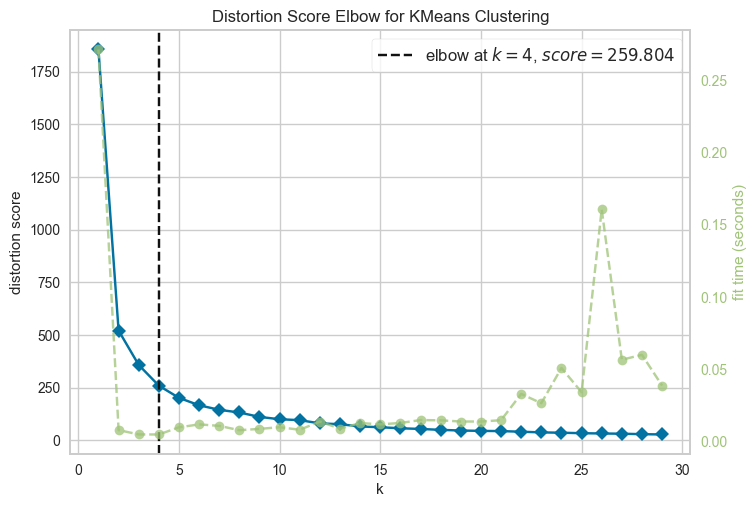

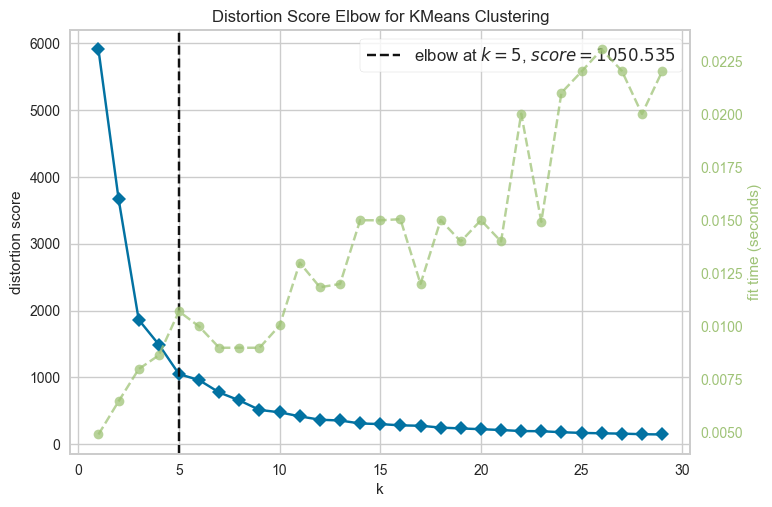

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# # Elbow Method Kios
# scaler = StandardScaler()

# kios_df['latitude'] = kios_df['LokasiLat']
# kios_df['longitude'] = kios_df['LokasiLong']

# # Filter the DataFrame based on latitude and longitude
# kios_df = kios_df[(kios_df['latitude'] < -7) & (kios_df['latitude'] > -8) & (kios_df['longitude'] < 112) & (kios_df['longitude'] > 108)]
# X = kios_df[["latitude","longitude"]].values
# X_scaled = scaler.fit_transform(X)

# model = KMeans(random_state=42, init="k-means++")
# visualizer = KElbowVisualizer(model, k=(1, 30))
# visualizer.fit(X)
# visualizer.ax.set_title("Distortion Score Elbow from X data")
# visualizer.show()

# visualizer = KElbowVisualizer(model, k=(1, 30))
# visualizer.fit(X_scaled)
# visualizer.ax.set_title("Distortion Score Elbow from X_scaled data")
# visualizer.show()

Optimal k based on Silhouette score: 2


C:\Users\DELL\AppData\Local\Temp\ipykernel_6284\1374044740.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


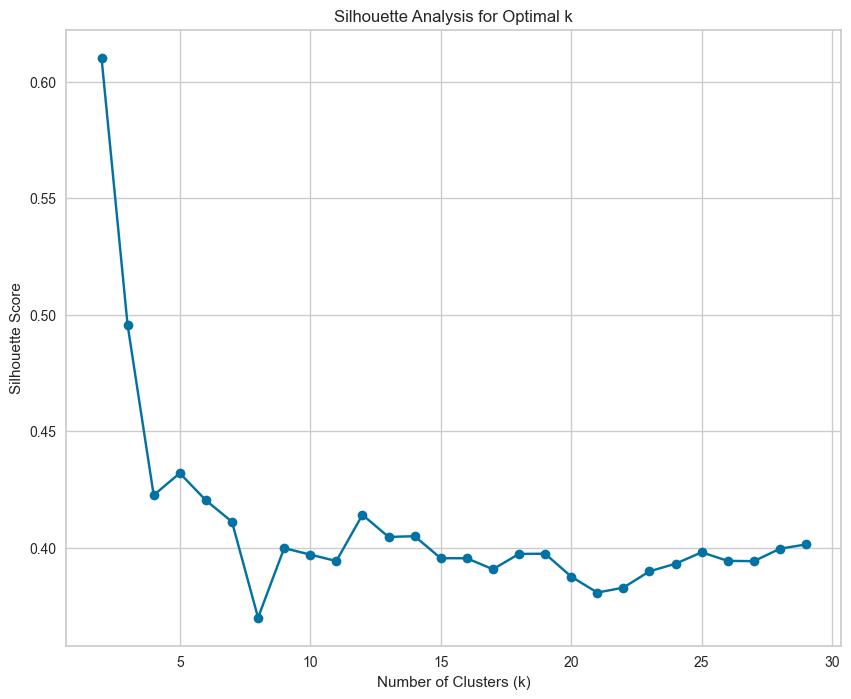

In [16]:
# # Silhouette analysis
# silhouette_scores = []
# for k in range(2, 30):  # Silhouette score is not defined for k=1
#     kmeans = KMeans(n_clusters=k, init='k-means++',random_state=42)
#     kmeans.fit(X)

#     if k>1:
#         silhouette_avg = silhouette_score(X, kmeans.labels_)
#         silhouette_scores.append(silhouette_avg)
#     else:
#         silhouette_score.append(-1)

# # Find the optimal k with the highest silhouette score
# optimal_k = np.argmax(silhouette_scores) + 2  # Adding 2 because the loop starts from k=2
# print(f"Optimal k based on Silhouette score: {optimal_k}")

# plt.figure(figsize=(10, 8))
# plt.plot(range(2, 30), silhouette_scores, marker='o')
# plt.title('Silhouette Analysis for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.legend()
# plt.show()

### Desa to DC

In [ ]:
alokasi_desa_df = pd.merge(
    left=desa_df,
    right=alokasi_df,
    how="left",
    left_on="kabkota",
    right_on="KabKotasKios"
)

# alokasi_desa_df.dropna(subset='Nama_Desa',inplace=True)
alokasi_desa_df.drop(columns=['Kabupaten/Kota','KabKota','KabKotasKios','Alokasi/bulan','Alokasi/tahun'],inplace=True)
alokasi_desa_df.rename(columns={'NPK Kakao':'NPK_Kakao'},inplace=True)
alokasi_desa_df.head()


,id,customers,address,kabkota,provinsi,alokasi_per_bulan,lat_customers,lon_customers,nearest_plant_existing,lat_plant_existing,lon_plant_existing,Urea,NPK,NPK_Kakao,Organik,Total,Kios,Desa,%kios/desa
0,Purbalingga - Kebong_ADIARSA,ADIARSA,-,KAB. PURBALINGGA,JAWA TENGAH,7.60,-7.28733,109.429,Purbalingga - Kebong,-7.40331,109.3588,11782.851,9710.729,4.139,303.0,21800.719,99.0,224.0,0.441964
1,GPP KEBUMEN_ADIKARSO,ADIKARSO,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.69377,109.673,GPP KEBUMEN,-7.61092,109.5078,25807.030,20532.569,0.000,40293.0,86632.599,148.0,449.0,0.329621
2,GPP KEBUMEN_ADIKARTO,ADIKARTO,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.66904,109.589,GPP KEBUMEN,-7.61092,109.5078,25807.030,20532.569,0.000,40293.0,86632.599,148.0,449.0,0.329621
3,GPP MAGELANG_ADIKARTO,ADIKARTO,-,KAB. MAGELANG,JAWA TENGAH,7.61,-7.60788,110.245,GPP MAGELANG,-7.39554,110.2447,18884.326,14776.635,0.000,307.0,33967.961,89.0,367.0,0.242507
4,GPP KEBUMEN_ADILUHUR,ADILUHUR,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.68421,109.559,GPP KEBUMEN,-7.61092,109.5078,25807.030,20532.569,0.000,40293.0,86632.599,148.0,449.0,0.329621


In [33]:
# gabungkan real_sales_df dengan unique_sonumber_df
alokasi_desa_ws_df = pd.merge(
    left=alokasi_desa_df,
    right=unique_sonumber_df,
    how="left",
    left_on='kabkota',
    right_on='Kab'
)

# mendapatkan stok_gudang (alokasi-realisasi penjualan)
# alokasi - realisasi penjualan
alokasi_desa_ws_df['over_under_stock_kab'] =  alokasi_desa_ws_df['Total'] - alokasi_desa_ws_df['realisasi_penjualan_kab']
alokasi_desa_ws_df['over_under_stock_kab'] = alokasi_desa_ws_df['over_under_stock_kab'].replace([np.inf, -np.inf], 0)

# realisasi/10 bulan (jan-okt)
alokasi_desa_ws_df['realisasi_penjualan_desa_per_bulan'] = (alokasi_desa_ws_df['realisasi_penjualan_kab'] / alokasi_desa_ws_df['Desa']) / 10
alokasi_desa_ws_df['realisasi_penjualan_desa_per_bulan'] = alokasi_desa_ws_df['realisasi_penjualan_desa_per_bulan'].replace([np.inf, -np.inf], 0)

# jumlah transaksi kabupaten/kios/12 bulan
alokasi_desa_ws_df['jumlah_transaksi_desa_per_bulan'] = (alokasi_desa_ws_df['jumlah_transaksi_kab'] / alokasi_desa_ws_df['Desa']) / 12
alokasi_desa_ws_df['jumlah_transaksi_desa_per_bulan'] = alokasi_desa_ws_df['jumlah_transaksi_desa_per_bulan'].replace([np.inf, -np.inf], 0)

# urea/desa/12 bulan
alokasi_desa_ws_df['urea_per_bulan'] = (alokasi_desa_ws_df['Urea']/alokasi_desa_ws_df['Desa']) / 12
alokasi_desa_ws_df['urea_per_bulan'] = alokasi_desa_ws_df['urea_per_bulan'].replace([np.inf, -np.inf], 0)

# NPK/kios/12 bulan
alokasi_desa_ws_df['NPK_per_bulan'] = (alokasi_desa_ws_df['NPK']/alokasi_desa_ws_df['Desa']) / 12
alokasi_desa_ws_df['NPK_per_bulan'] = alokasi_desa_ws_df['NPK_per_bulan'].replace([np.inf, -np.inf], 0)

pd.set_option('display.max_columns', None)
alokasi_desa_ws_df.head()

,id,customers,address,kabkota,provinsi,alokasi_per_bulan,lat_customers,lon_customers,nearest_plant_existing,lat_plant_existing,lon_plant_existing,Urea,NPK,NPK_Kakao,Organik,Total,Kios,Desa,%kios/desa,realisasi_penjualan_kab,jumlah_transaksi_kab,over_under_stock_kab,realisasi_penjualan_desa_per_bulan,jumlah_transaksi_desa_per_bulan,urea_per_bulan,NPK_per_bulan
0,Purbalingga - Kebong_ADIARSA,ADIARSA,-,KAB. PURBALINGGA,JAWA TENGAH,7.60,-7.28733,109.429,Purbalingga - Kebong,-7.40331,109.3588,11782.851,9710.729,4.139,303.0,21800.719,99.0,224.0,0.441964,8061.500,1271.0,13739.219,3.598884,0.472842,4.383501,3.612622
1,GPP KEBUMEN_ADIKARSO,ADIKARSO,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.69377,109.673,GPP KEBUMEN,-7.61092,109.5078,25807.030,20532.569,0.000,40293.0,86632.599,148.0,449.0,0.329621,11137.170,867.0,75495.429,2.480439,0.160913,4.789723,3.810796
2,GPP KEBUMEN_ADIKARTO,ADIKARTO,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.66904,109.589,GPP KEBUMEN,-7.61092,109.5078,25807.030,20532.569,0.000,40293.0,86632.599,148.0,449.0,0.329621,11137.170,867.0,75495.429,2.480439,0.160913,4.789723,3.810796
3,GPP MAGELANG_ADIKARTO,ADIKARTO,-,KAB. MAGELANG,JAWA TENGAH,7.61,-7.60788,110.245,GPP MAGELANG,-7.39554,110.2447,18884.326,14776.635,0.000,307.0,33967.961,89.0,367.0,0.242507,13375.785,1541.0,20592.176,3.644628,0.349909,4.287994,3.355276
4,GPP KEBUMEN_ADILUHUR,ADILUHUR,-,KAB. KEBUMEN,JAWA TENGAH,15.69,-7.68421,109.559,GPP KEBUMEN,-7.61092,109.5078,25807.030,20532.569,0.000,40293.0,86632.599,148.0,449.0,0.329621,11137.170,867.0,75495.429,2.480439,0.160913,4.789723,3.810796


In [34]:
alokasi_desa_ws_df.to_csv(desa_file_aws)
# alokasi_kios_ws_df.to_csv(kios_file_aws)

### Elbow & Silhouette Method

In [ ]:
# # Elbow Method
# scaler = StandardScaler()
# X = alokasi_desa_df[["LokasiLong","LokasiLat","alokasi_per_bulan"]]
# X_scaled = scaler.fit_transform(X)

# model = KMeans(random_state=42)
# visualizer = KElbowVisualizer(model, k=(1, 40))
# visualizer.fit(X)
# visualizer.ax.set_title("Distortion Score Elbow from X data")
# visualizer.show()

# visualizer = KElbowVisualizer(model, k=(1, 40))
# visualizer.fit(X_scaled)
# visualizer.ax.set_title("Distortion Score Elbow from X_scaled data")
# visualizer.show()

# # silhouette method
# # Silhouette analysis
# silhouette_scores = []
# for k in range(2, 35):  # Silhouette score is not defined for k=1
#     kmeans = KMeans(n_clusters=k,random_state=42)
#     kmeans.fit_predict(X)

#     if k>1:
#         silhouette_avg = silhouette_score(X, kmeans.labels_)
#         silhouette_scores.append(silhouette_avg)
#     else:
#         silhouette_score.append(-1)

# # Find the optimal k with the highest silhouette score
# optimal_k = np.argmax(silhouette_scores) + 2  # Adding 2 because the loop starts from k=2
# print(f"Optimal k based on Silhouette score: {optimal_k}")

# plt.figure(figsize=(10, 8))
# plt.plot(range(2, 35), silhouette_scores, marker='o')
# plt.title('Silhouette Analysis for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.legend()
# plt.show()

# silhouette_scores = []
# for k in range(2, 35):  # Silhouette score is not defined for k=1
#     kmeans = KMeans(n_clusters=k,random_state=42)
#     kmeans.fit_predict(X_scaled)

#     if k>1:
#         silhouette_avg = silhouette_score(X, kmeans.labels_)
#         silhouette_scores.append(silhouette_avg)
#     else:
#         silhouette_score.append(-1)

# # Find the optimal k with the highest silhouette score
# optimal_k = np.argmax(silhouette_scores) + 2  # Adding 2 because the loop starts from k=2
# print(f"Optimal k based on Silhouette score: {optimal_k}")

# plt.figure(figsize=(10, 8))
# plt.plot(range(2, 35), silhouette_scores, marker='o')
# plt.title('Silhouette Analysis for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.legend()
# plt.show()